In [1]:
import torch
import nvtabular as nvt
from nvtabular import dataset as ds
from nvtabular.merlin_models import torch as merlin

In [2]:
dataset = ds.MovieLens("/romeyn/data")

data = dataset.transform(overwrite=False, save=True)
stats = dataset.calculate_statistics(transformed=False, split_names="splits")

stats.display_overview()

In [3]:
dataloader_kwargs = dict(batch_size=20000, separate_labels=True, targets=["rating_binary"])

train_data = merlin.DataLoader.from_directory(data.get_dir("train"), **dataloader_kwargs)
eval_data = merlin.DataLoader.from_directory(data.get_dir("eval"), **dataloader_kwargs)

train_data.output_sizes

{'movieId': torch.Size([20000, 1]),
 'rating': torch.Size([20000, 1]),
 'userId': torch.Size([20000, 1]),
 'genres': torch.Size([20000, 10]),
 'rating_binary': torch.Size([20000, 1])}

In [4]:
inputs = merlin.TabularFeatures.from_column_group(train_data.columns, aggregation="concat")
inputs.build(train_data.output_sizes, device="cuda")
block = inputs >> merlin.MLPBlock([512, 256])

head = merlin.Head.from_column_group(train_data.columns, input_size=[256])
del head.tasks["rating"]

model = block.to_model(head)

model

BlockWithHead(
  (block): SequentialBlock(
    (0): TabularFeatures(
      (categorical_module): EmbeddingFeatures(
        (filter_features): FilterFeatures()
        (embedding_tables): ModuleDict(
          (movieId): EmbeddingBag(56585, 512, mode=mean)
          (userId): EmbeddingBag(162541, 512, mode=mean)
          (genres): EmbeddingBag(20, 16, mode=mean)
        )
      )
      (aggregation): ConcatFeatures()
    )
    (1): Sequential(
      (0): Linear(in_features=1040, out_features=512, bias=True)
      (1): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU(inplace=True)
    )
  )
  (head): Head(
    (tasks): ModuleDict(
      (rating_binary): Task(
        (metrics): ModuleList(
          (0): Precision()
          (1): Recall()
          (2): Accuracy()
        )
        (loss): BCELoss()
        (pre): Sequential(
          (0): Linear(in_features=256, out_features=1, bias=False)
          (1): Si

1001it [00:41, 24.31it/s]


{'precision': tensor(0.7289, device='cuda:0'), 'recall': tensor(0.7289, device='cuda:0'), 'accuracy': tensor(0.7289, device='cuda:0')}
{'precision': tensor(0.7463, device='cuda:0'), 'recall': tensor(0.7463, device='cuda:0'), 'accuracy': tensor(0.7463, device='cuda:0')}


1001it [00:40, 25.00it/s]


{'precision': tensor(0.7524, device='cuda:0'), 'recall': tensor(0.7524, device='cuda:0'), 'accuracy': tensor(0.7524, device='cuda:0')}
{'precision': tensor(0.7527, device='cuda:0'), 'recall': tensor(0.7527, device='cuda:0'), 'accuracy': tensor(0.7527, device='cuda:0')}


1001it [00:40, 24.73it/s]


{'precision': tensor(0.7592, device='cuda:0'), 'recall': tensor(0.7592, device='cuda:0'), 'accuracy': tensor(0.7592, device='cuda:0')}
{'precision': tensor(0.7557, device='cuda:0'), 'recall': tensor(0.7557, device='cuda:0'), 'accuracy': tensor(0.7557, device='cuda:0')}


1001it [00:43, 23.06it/s]


{'precision': tensor(0.7640, device='cuda:0'), 'recall': tensor(0.7640, device='cuda:0'), 'accuracy': tensor(0.7640, device='cuda:0')}
{'precision': tensor(0.7567, device='cuda:0'), 'recall': tensor(0.7567, device='cuda:0'), 'accuracy': tensor(0.7567, device='cuda:0')}


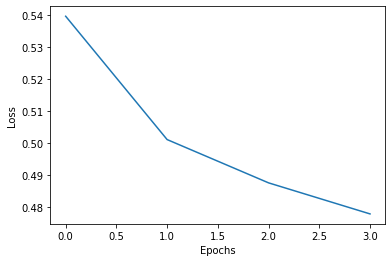

In [5]:
import matplotlib.pyplot as plt

losses = model.fit(train_data, eval_dataloader=eval_data, num_epochs=4, amp=False)

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()